In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
from scipy.interpolate import CubicSpline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import norm
from scipy.integrate import solve_ivp
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")
import arviz as az
import scipy.stats.kde as kde

# Calcualte absolute abundance

In [13]:
df_otu_97 = pd.read_csv('../../../our_data/otu_table_97.txt', sep='\t', skiprows=[0]).set_index('#OTU ID')
df_otu_97 = df_otu_97.div(df_otu_97.sum(axis=0), axis=1)
df_qpcr = pd.read_csv('../../../our_data/qPCR.csv', index_col=0)
for s in df_otu_97.columns:
    df_otu_97[s] = df_otu_97[s]*df_qpcr.loc[s,'Value']
df_otu_97.head()

,sample1,sample100,sample101,sample102,sample103,sample104,sample105,sample11,sample111,sample112,...,sample85,sample86,sample87,sample88,sample89,sample90,sample96,sample97,sample98,sample99
#OTU ID,,,,,,,,,,,,,,,,,,,,,
5fb94f804715b4d90f191c413efef44e,7.789012e+04,1.700092e+07,4.960669e+06,3.895579e+06,5.210754e+06,5.646639e+06,4.821300e+06,6.153718e+04,1.479671e+07,1.358852e+07,...,1.130849e+07,1.461786e+06,2.237159e+06,2.817831e+06,2.780238e+06,1.157717e+06,2.368749e+07,2.179704e+07,2.839400e+07,1.326783e+07
a8eb3e86e896febff5f3e223f84ba94b,1.771337e+07,3.041740e+06,2.185024e+06,1.989425e+06,4.270399e+06,5.354712e+06,7.044429e+06,2.006408e+07,1.006877e+06,6.123339e+05,...,1.252752e+07,9.732657e+06,1.274691e+07,1.144760e+07,8.665891e+06,1.311400e+07,6.219286e+06,5.713759e+06,5.921865e+06,3.517013e+06
dfa833b266bd2993b86feab3617b34c3,1.327017e+04,3.990491e+07,8.542836e+03,6.595689e+03,1.225219e+04,1.531084e+04,2.422764e+04,4.141926e+03,5.120712e+07,4.051231e+07,...,3.857674e+04,1.170335e+04,1.469667e+04,2.401415e+04,5.613402e+03,1.466370e+04,7.995319e+07,5.307300e+07,6.594444e+07,2.363116e+07
b6635d67cb594473ddba9f8cfba5d13d,1.382694e+07,1.744749e+07,3.892427e+06,7.766423e+05,9.985535e+06,1.453407e+07,1.454628e+07,1.908126e+07,2.311263e+07,4.452650e+07,...,3.591384e+07,7.919015e+06,2.006149e+07,1.580949e+07,1.526204e+07,1.518409e+07,4.089875e+07,3.291745e+07,3.790145e+07,3.308067e+07
1dcd5cddd286ba7e9e4786d8d8c1d201,0.000000e+00,1.035109e+04,8.542836e+03,4.122305e+03,1.072067e+04,7.145060e+03,1.550569e+04,5.917037e+03,0.000000e+00,2.267903e+04,...,4.408770e+03,2.642692e+03,8.709136e+03,8.685969e+03,6.816274e+03,5.364769e+03,2.463780e+04,1.996207e+04,1.887146e+04,9.879249e+03


# Generate files for stan program

In [6]:
# read meta data
df_meta = pd.read_csv('../../../our_data/meta_data.csv', index_col=0)
df_meta = df_meta[(df_meta.Diet=='Inulin') | (df_meta.Diet=='Control')]
df_meta['Diet'] = [1 if g=='Inulin' else 0 for g in df_meta['Diet']]

# read bacterial absolute abundance
df_bac = deepcopy(df_otu_97).T

# replace zeros with minimum non-zero values (since these values will be log-tranformed later)
for sample_id in df_bac.index:
    sample = np.array(df_bac.loc[sample_id])
    minval = np.min(sample[np.nonzero(sample)]) # minimum non-zero value
    sample[sample==0] = minval
    df_bac.loc[sample_id] = sample

# select the most abundant species
topN_taxa = 20
df_bac_T = df_bac.loc[df_meta.index].T
df_bac_T['mean'] = df_bac_T.mean(axis=1)
df_bac_T = df_bac_T.sort_values(by=['mean'],axis=0,ascending=False)
df_bac_T = df_bac_T.drop('mean', axis=1)
df_bac_topN_taxa = df_bac_T.iloc[0:topN_taxa].T
selected_bacterial_taxa = list(df_bac_topN_taxa.columns)

# normalize max abosolute value to 1
normalization_factor = df_bac_topN_taxa.max().max()
df_bac_topN_taxa = df_bac_topN_taxa/normalization_factor

# merge metadata and bacterial abundance
df_bac_topN_taxa_w_meta = pd.merge(df_meta, df_bac_topN_taxa, left_index=True, right_index=True, how='inner')

# calculate derivative of bacterial abundance
df_deriv = deepcopy(df_bac_topN_taxa_w_meta)
for curr_mice in set(df_deriv.MiceID):
    curr_df = df_deriv[df_deriv.MiceID==curr_mice]
    for taxon in selected_bacterial_taxa:
        xdata = np.array(curr_df['Day'])
        ydata = np.array(curr_df[taxon])
        cs = CubicSpline(xdata, ydata)
        csd1 = cs.derivative(nu=1)
        ydata_d1 = csd1(xdata)
        df_deriv.loc[df_deriv.MiceID==curr_mice, taxon] = ydata_d1

# construct regression matrix (Y~X)
Ymat = df_deriv[selected_bacterial_taxa].values # Ymat should be samples by bacteria
Ymat = Ymat.flatten(order='F')
Ymat = StandardScaler().fit_transform(Ymat.reshape(-1,1)).reshape(1,-1)[0] # standardize

Xmat = np.zeros(shape=(topN_taxa*len(df_deriv.index), (topN_taxa+2)*topN_taxa))
for k in np.arange(topN_taxa):
    Xmat[k*len(df_deriv.index):(k+1)*len(df_deriv.index),k*(topN_taxa+2)] = 1
    Xmat[k*len(df_deriv.index):(k+1)*len(df_deriv.index),k*(topN_taxa+2)+1] = df_deriv.Diet.values
    Xmat[k*len(df_deriv.index):(k+1)*len(df_deriv.index),k*(topN_taxa+2)+2:(k+1)*(topN_taxa+2)] = df_bac_topN_taxa_w_meta[selected_bacterial_taxa].values

# write data file
json_str = '{\n"N" : %d,\n'%(len(Ymat))
json_str += '\"dlogX\" : [%s],\n'%(','.join(list(Ymat.astype(str)))) # y variable
for k1,c1 in enumerate(selected_bacterial_taxa): # x variable
    # growth rate
    json_str += '\"growth_rate_%s\" : [%s],\n'%(c1,','.join(list(Xmat[:,k1*(topN_taxa+2)].astype(str))))
    # diet response
    json_str += '\"inulin_response_%s\" : [%s],\n'%(c1,','.join(list(Xmat[:,k1*(topN_taxa+2)+1].astype(str))))
    # bacterial interactions
    for k2,c2 in enumerate(selected_bacterial_taxa):
        v = list(Xmat[:,k1*(topN_taxa+2)+2+k2].astype(str))
        json_str += '\"pairwise_interaction_%s_%s\" : [%s]'%(c1,c2,','.join(v))
        if c1 == selected_bacterial_taxa[-1] and c2 == selected_bacterial_taxa[-1]:
            json_str += '\n}'
        else:
            json_str += ',\n'

text_file = open("inulin_mice_absolute_abundance_otu97_top%d.data.json"%(topN_taxa), "w")
text_file.write("%s" % json_str)
text_file.close()

# write model file
# data block
model_str = 'data {\n'
model_str += '\tint<lower=0> N;\n'
model_str += '\tvector[N] dlogX;\n'
for c1 in selected_bacterial_taxa:
    model_str += '\tvector[N] growth_rate_%s;\n'%(c1)
    model_str += '\tvector[N] inulin_response_%s;\n'%(c1)
    for c2 in selected_bacterial_taxa:
        model_str += '\tvector[N] pairwise_interaction_%s_%s;\n'%(c1,c2)
model_str += '}\n'

# parameter block
model_str += 'parameters {\n\treal<lower=0,upper=1> sigma;\n'
for c1 in selected_bacterial_taxa:
    model_str += '\treal alpha__%s;\n'%(c1) # growth rate
    model_str += '\treal epsilon__%s;\n'%(c1) # inulin response
    for c2 in selected_bacterial_taxa:
        model_str += '\treal beta__%s_%s;\n'%(c1,c2)
model_str += '}\n'       
        
# model block
model_str += 'model {\n\tsigma ~ uniform(0,1);\n'
for c1 in selected_bacterial_taxa:
    model_str += '\talpha__%s ~ normal(0,1);\n'%(c1) # growth rate
    model_str += '\tepsilon__%s ~ normal(0,1);\n'%(c1) # inulin response
    for c2 in selected_bacterial_taxa:
        model_str += '\tbeta__%s_%s ~ normal(0,1);\n'%(c1,c2)
model_str += '\tdlogX ~ normal('
for c1 in selected_bacterial_taxa:
    model_str += 'alpha__%s*growth_rate_%s+'%(c1,c1) # growth rate
    model_str += 'epsilon__%s*inulin_response_%s+'%(c1,c1) # inulin response
    for c2 in selected_bacterial_taxa:
        if c1 == selected_bacterial_taxa[-1] and c2 == selected_bacterial_taxa[-1]:
            model_str += 'beta__%s_%s*pairwise_interaction_%s_%s'%(c1,c2,c1,c2)
        else:
            model_str += 'beta__%s_%s*pairwise_interaction_%s_%s+'%(c1,c2,c1,c2)
model_str += ', sigma);\n}'

text_file = open("inulin_mice_absolute_abundance_otu97_top%d.stan"%(topN_taxa), "w")
text_file.write("%s" % model_str)
text_file.close()

In [9]:
selected_bacterial_taxa

['48ebe3984d06cbed00ccf035b936ad57',
 'dfa833b266bd2993b86feab3617b34c3',
 '5fb94f804715b4d90f191c413efef44e',
 'd272bf25781448dde9031a24679a9012',
 'd964f7ed79965fad0e0e92378840f658',
 '1dcd5cddd286ba7e9e4786d8d8c1d201',
 '70d55baf78e9ac4d0babeac5dcbae5c2',
 '0eebf22536faa70d10968eb4972b2736',
 '98a36346b6f54de07dc88dc9d746f58f',
 'b6635d67cb594473ddba9f8cfba5d13d',
 'a8eb3e86e896febff5f3e223f84ba94b',
 '0b438323a296b5f2ce2c8bbe3949ee8d',
 '7f1ba47a5fe9bbf536be6819b9ee0775',
 '3b8fae66a7abbaa263ab111ce4384c4e',
 'deabfa9b86859ef2403b750939009ee3',
 '608f5e62b077be5515e20c7190568cf6',
 'fc7bca7e6ec63b7d0a2f9cd2f566a854',
 '5fa91e7085571e2cbcd0e7d245975c76',
 'ffc36e27c82042664a16bcd4d380b286',
 'e6b05a69bc7fa8dc428caa3d409c9fbb']

# Read stan output and generate summary table

In [7]:
def hpd_grid(sample, alpha=0.05, roundto=2):
    """Calculate highest posterior density (HPD) of array for given alpha. 
    The HPD is the minimum width Bayesian credible interval (BCI). 
    The function works for multimodal distributions, returning more than one mode
    Parameters
    ----------
    
    sample : Numpy array or python list
        An array containing MCMC samples
    alpha : float
        Desired probability of type I error (defaults to 0.05)
    roundto: integer
        Number of digits after the decimal point for the results
    Returns
    ----------
    hpd: array with the lower 
          
    """
    sample = np.asarray(sample)
    sample = sample[~np.isnan(sample)]
    # get upper and lower bounds
    l = np.min(sample)
    u = np.max(sample)
    density = kde.gaussian_kde(sample)
    x = np.linspace(l, u, 2000)
    y = density.evaluate(x)
    #y = density.evaluate(x, l, u) waitting for PR to be accepted
    xy_zipped = zip(x, y/np.sum(y))
    xy = sorted(xy_zipped, key=lambda x: x[1], reverse=True)
    xy_cum_sum = 0
    hdv = []
    for val in xy:
        xy_cum_sum += val[1]
        hdv.append(val[0])
        if xy_cum_sum >= (1-alpha):
            break
    hdv.sort()
    diff = (u-l)/20  # differences of 5%
    hpd = []
    hpd.append(round(min(hdv), roundto))
    for i in range(1, len(hdv)):
        if hdv[i]-hdv[i-1] >= diff:
            hpd.append(round(hdv[i-1], roundto))
            hpd.append(round(hdv[i], roundto))
    hpd.append(round(max(hdv), roundto))
    ite = iter(hpd)
    hpd = list(zip(ite, ite))
    modes = []
    for value in hpd:
        x_hpd = x[(x > value[0]) & (x < value[1])]
        y_hpd = y[(x > value[0]) & (x < value[1])]
        modes.append(round(x_hpd[np.argmax(y_hpd)], roundto))
    return hpd, x, y, modes

In [8]:
fit = az.from_cmdstan(["stan_output_%d_raw_absolute_abundance_top20_otu.csv"%(i) for i in np.arange(1,4)])

lines = []
    
# basal growth rate
for taxa in selected_bacterial_taxa:
    var = 'alpha__%s'%(taxa)
    data = []
    for i in np.arange(0,3):
        data.extend(list(fit.posterior[var][i].values))
    hpd_mu, x_mu, y_mu, modes_mu = hpd_grid(data)
    assert len(hpd_mu) == 1
    (x0, x1) = hpd_mu[0]
    lines.append(['basal_growth_rate', taxa, var, x0, x1, (x0+x1)/2, np.median(data), np.mean(data)/np.std(data), x0*x1>0])
    
# inulin response
for taxa in selected_bacterial_taxa:
    var = 'epsilon__%s'%(taxa)
    data = []
    for i in np.arange(0,3):
        data.extend(list(fit.posterior[var][i].values))
    hpd_mu, x_mu, y_mu, modes_mu = hpd_grid(data)
    assert len(hpd_mu) == 1
    (x0, x1) = hpd_mu[0]
    lines.append(['inulin_response', taxa, var, x0, x1, (x0+x1)/2, np.median(data), np.mean(data)/np.std(data), x0*x1>0])

# pairwise interactions
for taxa1 in selected_bacterial_taxa:
    for taxa2 in selected_bacterial_taxa:
        var = 'beta__%s_%s'%(taxa1,taxa2)
        data = []
        for i in np.arange(0,3):
            data.extend(list(fit.posterior[var][i].values))
        hpd_mu, x_mu, y_mu, modes_mu = hpd_grid(data)
        assert len(hpd_mu) == 1
        (x0, x1) = hpd_mu[0]
        lines.append(['pairwise_interaction', (taxa1,taxa2), var, x0, x1, (x0+x1)/2, np.median(data), np.mean(data)/np.std(data), x0*x1>0])
    
df_stan_output_summary = pd.DataFrame(lines, columns = ['Type','Taxa','Variable','Left','Right','Middle','Median','SNR','Significant'])
df_stan_output_summary.to_excel('stan_output_summary_absolute_abundance_top20_otu.xlsx')
df_stan_output_summary.head()

,Type,Taxa,Variable,Left,Right,Middle,Median,SNR,Significant
0,basal_growth_rate,48ebe3984d06cbed00ccf035b936ad57,alpha__48ebe3984d06cbed00ccf035b936ad57,-0.26,0.05,-0.105,-0.103941,-1.320402,False
1,basal_growth_rate,dfa833b266bd2993b86feab3617b34c3,alpha__dfa833b266bd2993b86feab3617b34c3,-0.28,0.03,-0.125,-0.126707,-1.604702,False
2,basal_growth_rate,5fb94f804715b4d90f191c413efef44e,alpha__5fb94f804715b4d90f191c413efef44e,-0.24,0.07,-0.085,-0.084381,-1.072186,False
3,basal_growth_rate,d272bf25781448dde9031a24679a9012,alpha__d272bf25781448dde9031a24679a9012,-0.11,0.20,0.045,0.044552,0.565392,False
4,basal_growth_rate,d964f7ed79965fad0e0e92378840f658,alpha__d964f7ed79965fad0e0e92378840f658,-0.19,0.12,-0.035,-0.033874,-0.437384,False


# Show significant diet responders and species-species interactions

In [12]:
df_stan_output_summary = pd.read_excel('stan_output_summary_absolute_abundance_top20_otu.xlsx', index_col=0)
df_stan_output_summary = df_stan_output_summary[(df_stan_output_summary.Significant==True) & (df_stan_output_summary.Type=='inulin_response')]
df_stan_output_summary.sort_values('Median', ascending=False)

,Type,Taxa,Variable,Left,Right,Middle,Median,SNR,Significant
23,inulin_response,d272bf25781448dde9031a24679a9012,epsilon__d272bf25781448dde9031a24679a9012,1.58,2.11,1.845,1.847680,13.740623,True
22,inulin_response,5fb94f804715b4d90f191c413efef44e,epsilon__5fb94f804715b4d90f191c413efef44e,0.67,1.20,0.935,0.936770,6.961364,True
31,inulin_response,0b438323a296b5f2ce2c8bbe3949ee8d,epsilon__0b438323a296b5f2ce2c8bbe3949ee8d,0.66,1.19,0.925,0.924829,6.941640,True
28,inulin_response,98a36346b6f54de07dc88dc9d746f58f,epsilon__98a36346b6f54de07dc88dc9d746f58f,0.33,0.86,0.595,0.595110,4.429872,True
24,inulin_response,d964f7ed79965fad0e0e92378840f658,epsilon__d964f7ed79965fad0e0e92378840f658,0.33,0.86,0.595,0.593028,4.440497,True
27,inulin_response,0eebf22536faa70d10968eb4972b2736,epsilon__0eebf22536faa70d10968eb4972b2736,0.07,0.61,0.340,0.334327,2.458946,True
38,inulin_response,ffc36e27c82042664a16bcd4d380b286,epsilon__ffc36e27c82042664a16bcd4d380b286,0.01,0.55,0.280,0.281913,2.078830,True


In [11]:
df_stan_output_summary = pd.read_excel('stan_output_summary_absolute_abundance_top20_otu.xlsx', index_col=0)
df_stan_output_summary = df_stan_output_summary[(df_stan_output_summary.Significant==True) & (df_stan_output_summary.Type=='pairwise_interaction')]
df_stan_output_summary.sort_values('Median', ascending=False)

,Type,Taxa,Variable,Left,Right,Middle,Median,SNR,Significant
418,pairwise_interaction,"('ffc36e27c82042664a16bcd4d380b286', 'ffc36e27...",beta__ffc36e27c82042664a16bcd4d380b286_ffc36e2...,1.23,4.06,2.645,2.653900,3.703879,True
51,pairwise_interaction,"('48ebe3984d06cbed00ccf035b936ad57', '0b438323...",beta__48ebe3984d06cbed00ccf035b936ad57_0b43832...,0.64,3.59,2.115,2.121445,2.818680,True
208,pairwise_interaction,"('98a36346b6f54de07dc88dc9d746f58f', '98a36346...",beta__98a36346b6f54de07dc88dc9d746f58f_98a3634...,0.59,3.49,2.040,2.043330,2.773522,True
108,pairwise_interaction,"('d272bf25781448dde9031a24679a9012', '98a36346...",beta__d272bf25781448dde9031a24679a9012_98a3634...,0.48,3.34,1.910,1.914755,2.632606,True
42,pairwise_interaction,"('48ebe3984d06cbed00ccf035b936ad57', '5fb94f80...",beta__48ebe3984d06cbed00ccf035b936ad57_5fb94f8...,0.34,3.39,1.865,1.872105,2.416950,True
40,pairwise_interaction,"('48ebe3984d06cbed00ccf035b936ad57', '48ebe398...",beta__48ebe3984d06cbed00ccf035b936ad57_48ebe39...,0.47,1.82,1.145,1.143915,3.343263,True
200,pairwise_interaction,"('98a36346b6f54de07dc88dc9d746f58f', '48ebe398...",beta__98a36346b6f54de07dc88dc9d746f58f_48ebe39...,-1.38,-0.04,-0.710,-0.714364,-2.097159,True
120,pairwise_interaction,"('d964f7ed79965fad0e0e92378840f658', '48ebe398...",beta__d964f7ed79965fad0e0e92378840f658_48ebe39...,-1.69,-0.37,-1.030,-1.035090,-3.087039,True
80,pairwise_interaction,"('5fb94f804715b4d90f191c413efef44e', '48ebe398...",beta__5fb94f804715b4d90f191c413efef44e_48ebe39...,-2.08,-0.75,-1.415,-1.420305,-4.217250,True
401,pairwise_interaction,"('ffc36e27c82042664a16bcd4d380b286', 'dfa833b2...",beta__ffc36e27c82042664a16bcd4d380b286_dfa833b...,-2.85,-0.07,-1.460,-1.475190,-2.090453,True


In [ ]:
108,104,102,262,107

# Plot posterior distribution

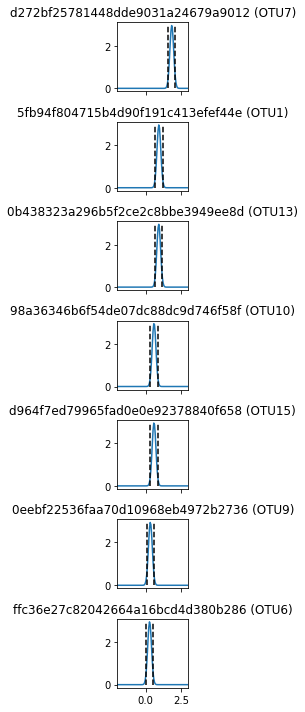

In [16]:
fit = az.from_cmdstan(["stan_output_%d_raw_absolute_abundance_top20_otu.csv"%(i) for i in np.arange(1,4)])

# find inulin responders
df_stan_output_summary = pd.read_excel('stan_output_summary_absolute_abundance_top20_otu.xlsx', index_col=0)
df_stan_output_summary = df_stan_output_summary[df_stan_output_summary.Significant==True]
df_stan_output_summary = df_stan_output_summary[df_stan_output_summary.Type=='inulin_response'].sort_values('Median', ascending=False).reset_index(drop=True)

# plot
fig, ax = plt.subplots(figsize=(3,10), nrows=len(df_stan_output_summary.index), ncols=1, sharex=True)

for idx in df_stan_output_summary.index:
    _type = df_stan_output_summary.loc[idx,'Type']
    _taxa = df_stan_output_summary.loc[idx,'Taxa']
    _left = df_stan_output_summary.loc[idx,'Left']
    _middle = df_stan_output_summary.loc[idx,'Middle']
    _right = df_stan_output_summary.loc[idx,'Right']
    if _type == 'inulin_response':
        var = 'epsilon__%s'%(_taxa)
    if _type == 'pairwise_interaction':
        var = 'beta__%s_%s'%(eval(_taxa)[0],eval(_taxa)[1])
    data = []
    for i in np.arange(0,3):
        data.extend(list(fit.posterior[var][i].values))
    mean,std=norm.fit(data)
    x = np.linspace(-2, 3, 100)
    ax[idx].set_xlim([-2,3])
    y = norm.pdf(x, mean, std)
    ax[idx].plot(x,y)
    ax[idx].plot([_left,_left],[0,np.max(y)], 'k--')
    ax[idx].plot([_right,_right],[0,np.max(y)], 'k--')
    ax[idx].set_title(_taxa+' (OTU%d)'%(list(df_otu_97.index).index(_taxa)+1))
    
plt.tight_layout() 
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("posterior_distribution_inulin_responders_absolute_abundance_top20_otus.svg", format="svg")